In [29]:
# Mathematical operations
import numpy as np

# Deep learning library + differentiable QP solver
import torch
try:
    import qpth
except ModuleNotFoundError:
    !pip install git+https://github.com/locuslab/qpth
    import qpth

# Plots
import matplotlib.pyplot as plt

# Functions and classes in models.py
from models import fix_seed_and_device, train, plot_progression, OptNetDenoiser, DenseNetDenoiser

# Others
import warnings
from typing import Optional, Callable

warnings.filterwarnings('ignore')

In [30]:
device = fix_seed_and_device()
print(device)

cpu


# Denoising problem

Given a noised time series $y\in\mathbb R^T$, we want to denoise it, i.e., we want to find a time series $z^*$ that is as close as possible to $y$, but satisfies some regularity condition. The **total variation denoising method** (TV) consists in solving the following problem:

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12|\!|y-z|\!|_2^2 + \lambda |\!|Dz|\!|_1
\end{equation}

where $\lambda > 0$ is a hyperparameter and $D\in\mathbb R^{(T-1)\times T}$ maps $z$ to its temporal differences $Dz=(z_2-z_1, z_3-z_2,\cdots,z_T-z_{T-1})^\top$.

This problem can be approximated by an OptNet. In fact, by the Lagrange multiplier theorem, this problem is equivalent to

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12|\!|y-z|\!|_2^2 \quad \text{subject to} \quad  |\!|Dz|\!|_1 \leq \vartheta
\end{equation}

for some $\vartheta > 0$. This constraint forces $Dz$ to belong in an $\ell_1$ ball, which is in fact a polytope. The constraint can thus be re-written as 

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12|\!|y-z|\!|_2^2 \quad \text{subject to} \quad  \Gamma Dz \leq \theta
\end{equation}

where $\Gamma \in\mathbb \{-1,1\}^{2^{T-1}\times T-1}$ is a matrix obtained by stacking all $2^{T-1}$ elements of $\{-1,1\}^{T-1}$, and $\theta\in\mathbb R^{T-1}$ is a vector whose entries are all equal to $\vartheta$.
Finally, the objective function is clearly quadratic in $z$, yielding the following representation:

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12z^\top z - z^\top y \quad \text{subject to} \quad  \Gamma Dz \leq \theta
\end{equation}

which corresponds to a usual quadratic program with $Q=I_T$, $p=-y$, $G=\Gamma D$, $h=\theta$, and no equality constraints. In practice, $\Gamma D$ and $\theta$ have too many lines ($2^{T-1}$) to be used, so we will reduce the number of inequality constraints to make the problem solvable. In our experiment, we set the number of inequality constraints to $2(T-1)$ and initialize $\Gamma$ as $$ \Gamma = \begin{pmatrix} I_{T-1} \\ -I_{T-1} \end{pmatrix} $$ so that the constraint $\Gamma Dz \leq \theta$ is equivalent to $|\!|Dz|\!|_\infty \leq \vartheta$.

The model will learn the product $G=\Gamma D \in\mathbb R^{2(T-1)\times T}$ as well as $\vartheta\in\mathbb R$. Learning $D$ allows to modify the regularity constraint imposed to $z^*$. We initialize $D$ as the matrix of the first-difference operator, as in the TV method.

# 1. Dataset generation

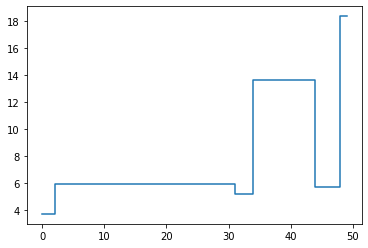

In [31]:
def generate_piecewise_constant(length:int, min_steps=1, max_steps=7, min_value=0, max_value=20):
    """
    Generate a piecewise-constant time series of the given length.
    The locations of the discontinuities are selected uniformly. 
    The values on the different intervals are also uniform draws.
    """
    nb_jumps = np.random.randint(min_steps, max_steps+1)
    jumps = sorted(np.random.randint(length, size=nb_jumps))
    jumps = [0, *jumps, length]
    y = np.zeros(length)
    for i in range(len(jumps)-1):
        y[ jumps[i] : jumps[i+1] ] = np.random.uniform(min_value, max_value)
    return y

plt.step(x=range(50), y=generate_piecewise_constant(50), where='pre');

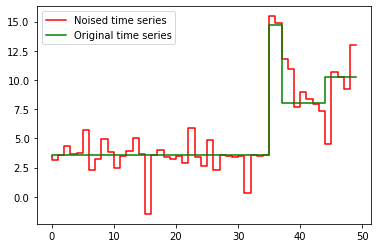

In [32]:
def add_gaussian_noise(y:np.ndarray, sigma:float=1):
    """
    Corrupts the time series y with a white gaussian noise.
    """
    return y + np.random.normal(loc=0, scale=sigma, size=y.shape)

def add_normal_gamma_noise(y:np.ndarray, alpha:float=1, beta:float=1):
    """
    Corrupts the time series y with a random noise.
    The noise at time t is drawn from a normal-gamma distribution with parameters (0, 1, alpha, beta).
    """
    sigmas = np.random.gamma(1, 1, size=y.shape)
    noise = np.vectorize(lambda sigma: np.random.normal(loc=0, scale=sigma))(sigmas)
    return y + noise


def plot(original:np.ndarray, noised:np.ndarray, denoised:Optional[np.ndarray]=None):
    fig, ax = plt.subplots(figsize=(6,4))
    ts = np.arange(noised.shape[0])
    ax.step(x=ts, y=noised, color='red', label='Noised time series')
    if denoised is not None:
        ax.step(x=ts, y=denoised, color='blue', label='Denoised time series')
    ax.step(x=ts, y=original, color='green', label='Original time series')
    ax.legend()
    return fig, ax

y = generate_piecewise_constant(50)
n = add_normal_gamma_noise(y)
plot(y, n);

In [33]:
class PiecewiseConstantDataset(torch.utils.data.Dataset):
    def __init__(self, length:int=20, size:int=1_000, noise_func:Callable=add_gaussian_noise, **noise_func_kwargs):
        self.original, self.noised = [], []
        for _ in range(size):
            y = generate_piecewise_constant(length)
            self.original.append(torch.from_numpy(y).float())
            n = noise_func(y, **noise_func_kwargs)
            self.noised.append(torch.from_numpy(n).float())
    
    def __len__(self):
        return len(self.original)
    
    def __getitem__(self, idx:int):
        return dict(
            original = self.original[idx],
            noised = self.noised[idx]
        )

BATCH_SIZE = 100
SERIES_LENGTH = 50

trainset = PiecewiseConstantDataset(length=SERIES_LENGTH, size=1_000, noise_func=add_normal_gamma_noise)
valset = PiecewiseConstantDataset(length=SERIES_LENGTH, size=200, noise_func=add_normal_gamma_noise)
testset = PiecewiseConstantDataset(length=SERIES_LENGTH, size=200, noise_func=add_normal_gamma_noise)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
def plot_example(dataset, idx, model):
    original = dataset[idx]['original']
    noised = dataset[idx]['noised']
    denoised = model(dataset[idx]['noised']).squeeze().detach()
    fig, ax = plot(original, noised, denoised)
    ax.set_title("MSE: {:.4f}".format(torch.mean((original-denoised)**2).item()))
    return fig, ax

# 2. Denoising with a feed-forward dense network

Epoch 10/200, val loss: 15.36
Epoch 20/200, training loss: 9.864
Epoch 20/200, val loss: 9.684
Epoch 30/200, val loss: 7.109
Epoch 40/200, training loss: 5.706
Epoch 40/200, val loss: 5.698
Epoch 50/200, val loss: 4.814
Epoch 60/200, training loss: 4.165
Epoch 60/200, val loss: 4.193
Epoch 70/200, val loss: 3.729
Epoch 80/200, training loss: 3.324
Epoch 80/200, val loss: 3.371
Epoch 90/200, val loss: 3.078
Epoch 100/200, training loss: 2.779
Epoch 100/200, val loss: 2.838
Epoch 110/200, val loss: 2.64
Epoch 120/200, training loss: 2.398
Epoch 120/200, val loss: 2.472
Epoch 130/200, val loss: 2.32
Epoch 140/200, training loss: 2.119
Epoch 140/200, val loss: 2.2
Epoch 150/200, val loss: 2.088
Epoch 160/200, training loss: 1.909
Epoch 160/200, val loss: 1.993
Epoch 170/200, val loss: 1.908
Epoch 180/200, training loss: 1.749
Epoch 180/200, val loss: 1.84
Epoch 190/200, val loss: 1.769
Epoch 200/200, training loss: 1.625
Epoch 200/200, val loss: 1.714


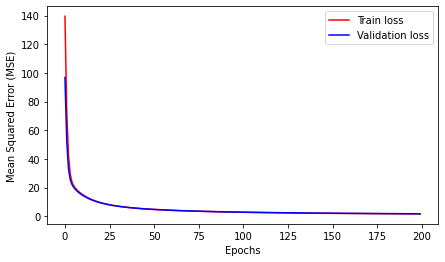

In [35]:
model = DenseNetDenoiser(SERIES_LENGTH, init_mode='random')
train_losses, val_losses, model = train(
    model = model,
    train_loader = trainloader,
    val_loader = valloader,
    optimizer = torch.optim.Adam(model.parameters(), lr=.001),
    loss_fn = torch.nn.MSELoss(),
    n_epochs = 200
)
plot_progression(train_losses, val_losses);

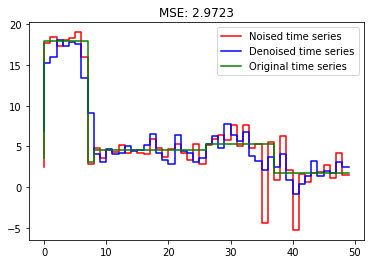

In [36]:
plot_example(testset, 0, model);

# 2. Denoising with OptNet

The OptNet model learns $\vartheta$, $\Gamma$ and $D$, with the initialization specified earlier.

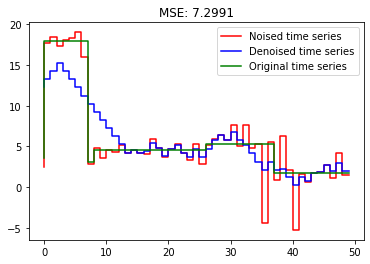

In [37]:
model = OptNetDenoiser(SERIES_LENGTH, init_mode='tv')
plot_example(testset, 0, model);


--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------


--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------


--------
qpth warning: Returning an i

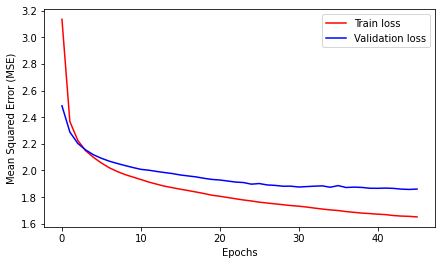

In [38]:
train_losses, val_losses, model = train(
    model = model,
    train_loader = trainloader,
    val_loader = valloader,
    optimizer = torch.optim.Adam(model.parameters(), lr=.001),
    loss_fn = torch.nn.MSELoss(),
    n_epochs = 200
)
plot_progression(train_losses, val_losses);

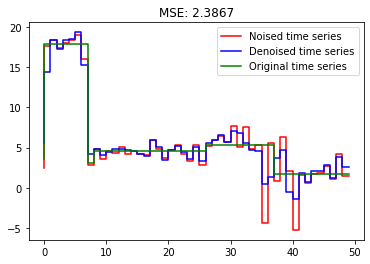

In [39]:
plot_example(testset, 0, model);